In [11]:
# Import necessary packages
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import os

data = np.load('dermamnist_64.npz')
print(data.files)

['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']


In [12]:
# Load the DermaMNIST dataset using the official train/val/test split
train_images = data['train_images']
train_labels = data['train_labels']
val_images = data['val_images']
val_labels = data['val_labels']
test_images = data['test_images']
test_labels = data['test_labels']

print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Validation images shape: {val_images.shape}')
print(f'Validation labels shape: {val_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train images shape: (7007, 64, 64, 3)
Train labels shape: (7007, 1)
Validation images shape: (1003, 64, 64, 3)
Validation labels shape: (1003, 1)
Test images shape: (2005, 64, 64, 3)
Test labels shape: (2005, 1)


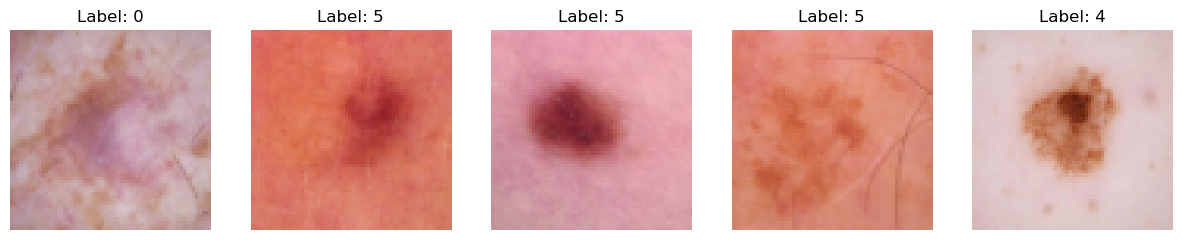

In [13]:
import matplotlib.pyplot as plt

# Function to visualize sample images with labels
def visualize_samples(images, labels, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i][0]}")
        plt.axis('off')
    plt.show()

# Visualize train images with labels
visualize_samples(train_images, train_labels)

Number of training samples: 7007
Number of validation samples: 1003
Number of test samples: 2005


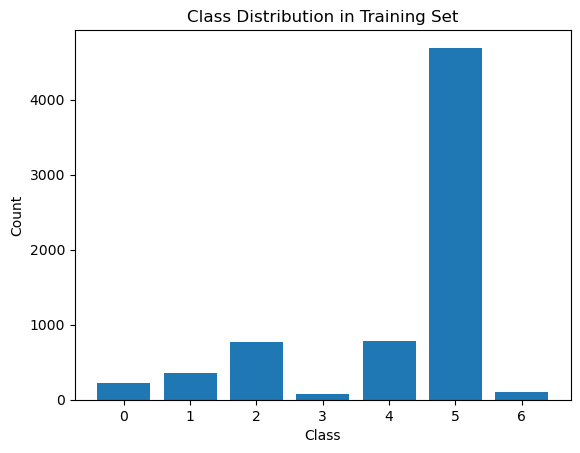

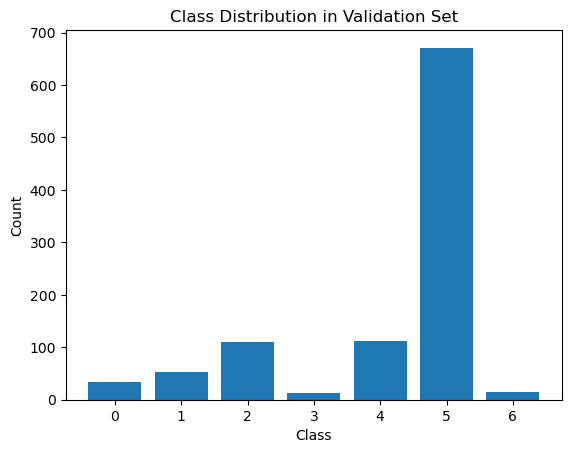

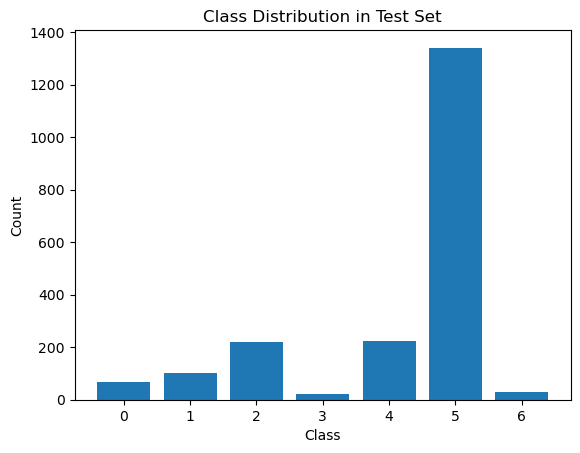

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate and print the number of samples in each data split
num_train = train_labels.shape[0]
num_val = val_labels.shape[0]
num_test = test_labels.shape[0]

print(f'Number of training samples: {num_train}')
print(f'Number of validation samples: {num_val}')
print(f'Number of test samples: {num_test}')

# Function to plot class distribution
def plot_class_distribution(labels, title):
    classes, counts = np.unique(labels, return_counts=True)
    plt.bar(classes, counts, tick_label=[str(c) for c in classes])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

# Plot class distribution for each dataset split
plot_class_distribution(train_labels, 'Class Distribution in Training Set')
plot_class_distribution(val_labels, 'Class Distribution in Validation Set')
plot_class_distribution(test_labels, 'Class Distribution in Test Set')

Number of training samples: 7007
Number of validation samples: 1003
Number of test samples: 2005


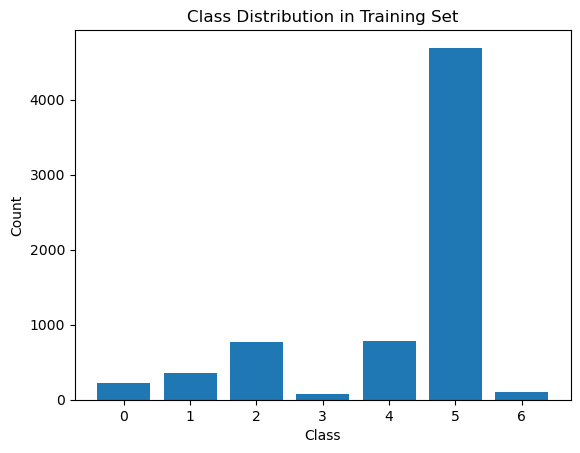

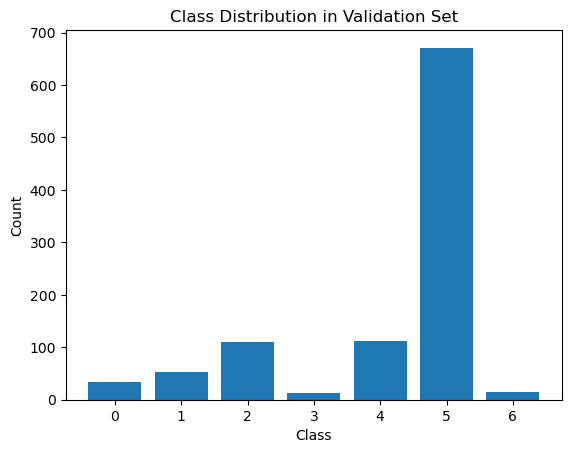

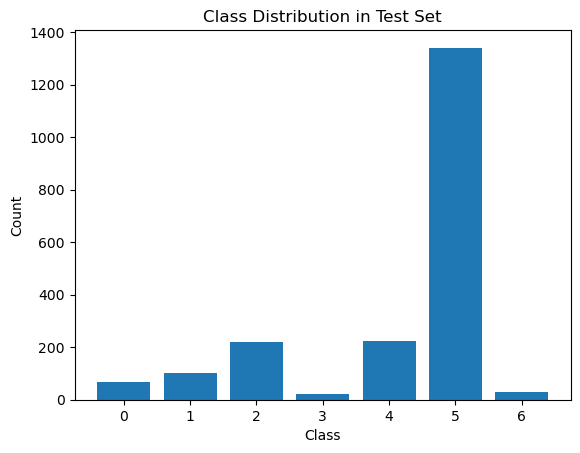

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate and print the number of samples in each data split
num_train = train_labels.shape[0]
num_val = val_labels.shape[0]
num_test = test_labels.shape[0]

print(f'Number of training samples: {num_train}')
print(f'Number of validation samples: {num_val}')
print(f'Number of test samples: {num_test}')

# Function to plot class distribution
def plot_class_distribution(labels, title):
    classes, counts = np.unique(labels, return_counts=True)
    plt.bar(classes, counts, tick_label=[str(c) for c in classes])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

# Plot class distribution for each dataset split
plot_class_distribution(train_labels, 'Class Distribution in Training Set')
plot_class_distribution(val_labels, 'Class Distribution in Validation Set')
plot_class_distribution(test_labels, 'Class Distribution in Test Set')


In [17]:
import torch
from torchvision import transforms
from PIL import Image

# Define transformations for training and test datasets
transform_train = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Assume train_images, val_images, and test_images are numpy arrays
# Apply transformations to datasets
train_images_transformed = torch.stack([transform_train(img) for img in train_images])
val_images_transformed = torch.stack([transform_test(img) for img in val_images])
test_images_transformed = torch.stack([transform_test(img) for img in test_images])

In [19]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.models import resnet18
from torch.utils.data import DataLoader, TensorDataset

# Load the transformed datasets (TensorDatasets)
train_dataset = TensorDataset(train_images_transformed, torch.tensor(train_labels, dtype=torch.long).squeeze())
val_dataset = TensorDataset(val_images_transformed, torch.tensor(val_labels, dtype=torch.long).squeeze())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained ResNet18 and modify the final layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=True)
num_classes = len(np.unique(train_labels))
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Freeze layers (optional)
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Define loss function, optimizer, and hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 20
early_stopping_patience = 5

# Training loop
best_val_loss = float('inf')
patience = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience += 1
        if patience >= early_stopping_patience:
            print("Early stopping triggered.")
            break

C:\Users\IMPACT\miniconda3\envs\py11\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\IMPACT\miniconda3\envs\py11\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\IMPACT/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:07<00:00, 6.35MB/s]


Epoch 1/20, Train Loss: 1.0432, Validation Loss: 2.6602, Validation Accuracy: 0.6630
Epoch 2/20, Train Loss: 0.9415, Validation Loss: 2.7395, Validation Accuracy: 0.6640
Epoch 3/20, Train Loss: 0.9081, Validation Loss: 3.6138, Validation Accuracy: 0.6660
Epoch 4/20, Train Loss: 0.8917, Validation Loss: 3.4167, Validation Accuracy: 0.6640
Epoch 5/20, Train Loss: 0.8849, Validation Loss: 3.1460, Validation Accuracy: 0.6600
Epoch 6/20, Train Loss: 0.8760, Validation Loss: 3.8100, Validation Accuracy: 0.6630
Early stopping triggered.


C:\Users\IMPACT\AppData\Local\Temp\ipykernel_3804\3544621767.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Accuracy: 0.6678, Precision: 0.5079, Recall: 0.6678, F1-Score: 0.5429
AUC: 0.5691


C:\Users\IMPACT\miniconda3\envs\py11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


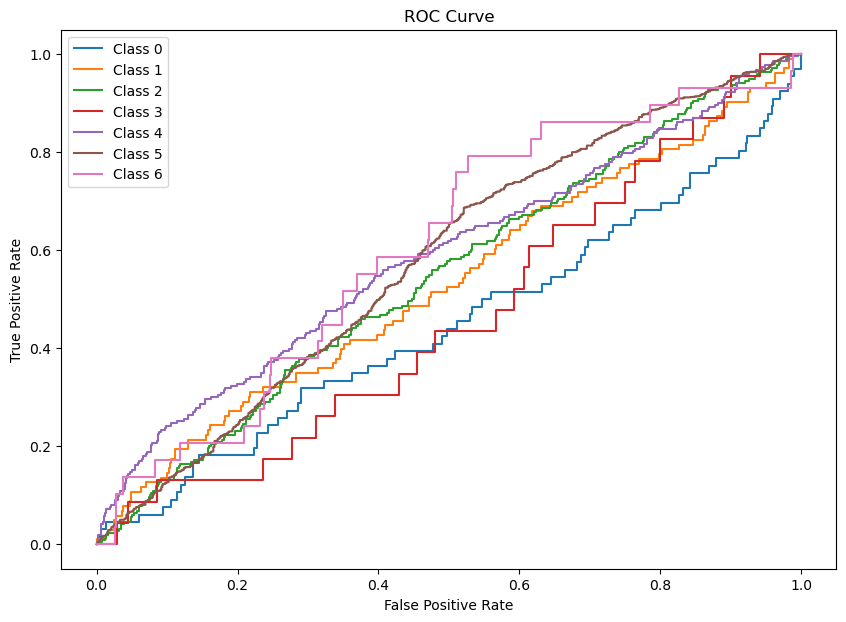

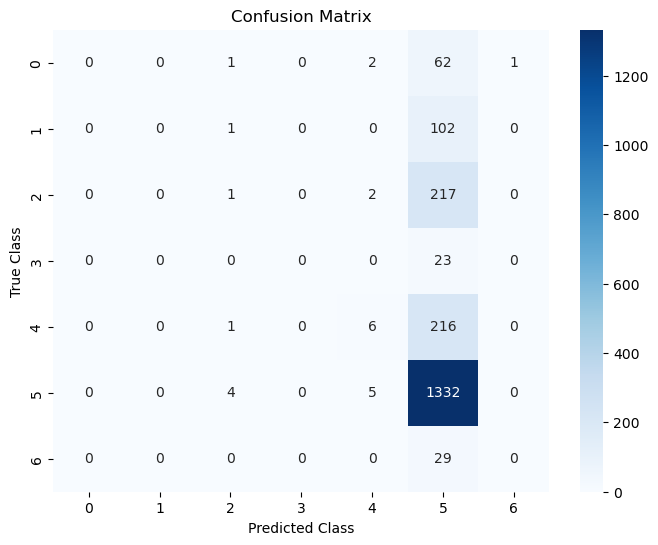

In [20]:


import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Evaluate on the test set
test_loader = DataLoader(
    TensorDataset(test_images_transformed, torch.tensor(test_labels, dtype=torch.long).squeeze()),
    batch_size=32, shuffle=False
)

all_labels, all_preds, all_probs = [], [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Compute ROC AUC (one-vs-rest for multi-class)
all_labels_one_hot = np.eye(num_classes)[np.array(all_labels)]
auc = roc_auc_score(all_labels_one_hot, np.array(all_probs), average="weighted", multi_class="ovr")
print(f"AUC: {auc:.4f}")

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels_one_hot[:, i], np.array(all_probs)[:, i])
    plt.plot(fpr, tpr, label=f"Class {i}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()